#Import Dependencies

In [4]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/AF')

In [5]:
from util import util, model_util
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import sklearn
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


#Training with LSTM

##Load data

In [ ]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)
signals, labels = util.preprocessing(signals, labels, timedistributed=True)
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9)
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (7425, 3, 1250, 1)
train_label shape: (7425, 1)

In training data:
There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 62 AF labels
There are 261 Other Arrhythmia labels


(502, 62, 261)

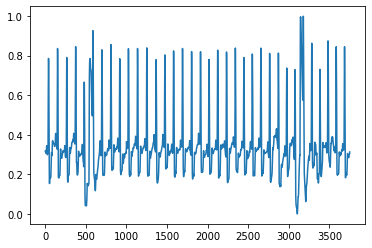

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_signals[2].reshape([3750,1]))

In [ ]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
test_signals, test_labels = util.preprocessing(test_signals, test_labels, timedistributed=True)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 3, 1250, 1)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

##TF Pipeline

In [ ]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
## loading
batch_size = 32
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

##Model

In [ ]:
#cnn + lstm model
model = model_util.cnn_lstm((3,1250,1), classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 1216)           9776      
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 64)             319744    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 339,987
Trainable params: 339,715
Non-trainable params: 272
_________________________________________________________________


In [ ]:
model = model_util.resnet18_lstm(3, 32, 16, 1250, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

##Callbacks

In [ ]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NO Afib','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

##Model Training

In [ ]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

#Training with Autoencoder

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

In [ ]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models")
ecg_encoder = tf.keras.models.load_model('ECG_Encoder.h5')
conv_encoder_clone = tf.keras.models.clone_model(ecg_encoder)

In [ ]:
def encoder_lstm(input_shape=(3,1250,1), classes=3):
  X_input = Input(shape=input_shape)
  X = TimeDistributed(conv_encoder_clone)(X_input)
  X = TimeDistributed(Flatten())(X)
  X = Bidirectional(LSTM(32, return_sequences=True))(X)
  X = Bidirectional(LSTM(16))(X)
  X = Dense(classes, activation='softmax')(X)

  model = Model(inputs=[X_input], outputs=X)

  return model

In [ ]:
model = encoder_lstm(input_shape=(3,1250,1), classes=3)

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 1250, 16)       53328     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 3, 20000)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 3, 64)             5128448   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 5,192,243
Trainable params: 5,138,915
Non-trainable params: 53,328
_______________________________________

In [ ]:
conv_encoder_clone.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

#Training with Spectrogram

In [6]:
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)

In [7]:
def get_spectrogram(signal):
  freq, time, spectrogram = scipy.signal.spectrogram(signal, fs=300, window='hanning',
                                                     nperseg=1024, noverlap=1024 - 128,
                                                     detrend=False, scaling='spectrum',
                                                     nfft=1024)
  spectrogram = np.log(spectrogram[(freq <= 10) & (freq > 0.01)])
  spectrogram = sklearn.preprocessing.minmax_scale(spectrogram)
  return spectrogram

In [8]:
get_spectrogram(signals[0]).shape

(34, 63)

In [9]:
def plot_spectrogram(signals, labels, type=0):
  
  type_idx = np.where(labels == type)[0]
  i = np.random.choice(type_idx, 1)
  i = int(i)  
  def get_label(label):
    if label == 0:
      return 'NSR'
    if label == 1:
      return 'AF'
    if label == 2:
      return 'Others'
  
  spectrogram = get_spectrogram(signals[i])

  fig, axes = plt.subplots(2, figsize=(12, 8))
  fig.tight_layout(pad=5.0)
  #ECG raw signal
  axes[0].plot(signals[0])
  axes[0].set_title(get_label(labels[i]))
  axes[0].set_xlabel('Samples', fontsize=15)
  axes[0].set_ylabel('ADC counts', fontsize=15)
  #spectrogram
  im = axes[1].pcolormesh(spectrogram)
  fig.colorbar(im, ax=axes[1])
  axes[1].set_title('Spectrogram', fontsize=15)
  axes[1].set_ylabel('Frequency (Hz)', fontsize=15)
  axes[1].set_xlabel('Time (s)', fontsize=15)
  plt.show()

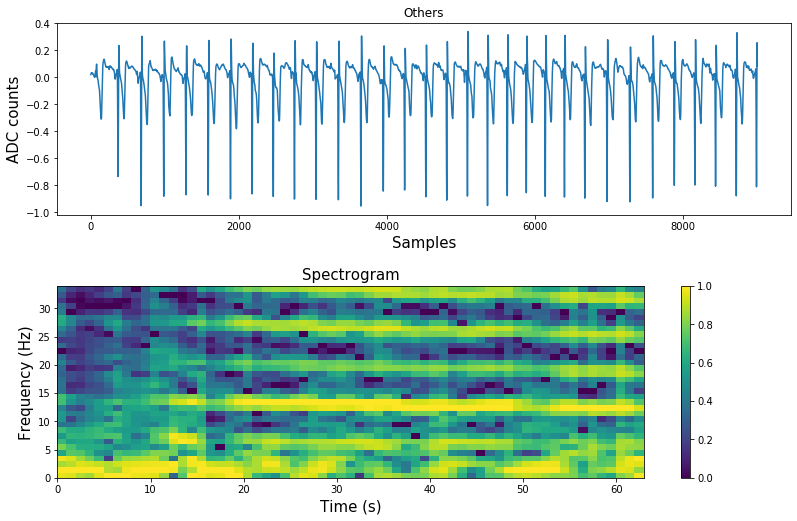

In [10]:
plot_spectrogram(signals, labels, 2)

In [11]:
def get_spectrogram_and_label(signal, label):
  spectrogram = tf.py_function(get_spectrogram, inp=[signal], Tout=tf.float32)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram, label

In [12]:
spectrogram, label = get_spectrogram_and_label(signals[0], labels[0])

In [17]:
type(spectrogram)

tensorflow.python.framework.ops.EagerTensor

In [13]:
print('Spectrom shape:', get_spectrogram_and_label(signals[0], labels[0])[0].shape)
print('Label shape:', get_spectrogram_and_label(signals[0], labels[0])[1].shape)

Spectrom shape: (34, 63, 1)
Label shape: (1,)


In [14]:
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9, seed=10)

In [15]:
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (7425, 9000)
train_label shape: (7425, 1)

In training data:
There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 62 AF labels
There are 261 Other Arrhythmia labels


(502, 62, 261)

In [18]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
train_dataset = train_dataset.map(get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## loading
batch_size = 32
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [20]:
train_dataset

<PrefetchDataset shapes: (<unknown>, (32, 1)), types: (tf.float32, tf.int32)>

In [ ]:
list(train_dataset.take(1).as_numpy_iterator())

In [24]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

# tensorflow input shape = (m, 69, 129, 1)
# Better to experiment with different filter size and strides
## Experiment with batch normalization to see if it improve accuracy
#clear history if necessary
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    #1st Conv2D
    tf.keras.layers.Input(shape=(34,63,1)),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    #tf.keras.layers.Dropout(0.2),
    #2nd Conv2D
    tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    #tf.keras.layers.Dropout(0.2),
    #3rd Conv2D
    tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    tf.keras.layers.Dropout(0.2),
    #4th Conv2D
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    tf.keras.layers.Dropout(0.2),
    #5th Conv2D
    tf.keras.layers.Conv2D(16, (1, 1), strides=(1, 1),
                           activation='relu'),
    #Full connection layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 34, 63, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 34, 63, 8)         16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 62, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 59, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 56, 32)        0

In [25]:
val_spectrogram = []
for val_signal in val_signals:
  val_spectrogram.append(get_spectrogram(val_signal))

val_signals_cm = np.array(val_spectrogram)
val_signals_cm = tf.expand_dims(val_signals_cm, -1)
val_signals_cm.shape

TensorShape([825, 34, 63, 1])

In [26]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals_cm)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NSR','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels
Epoch 1/200
  1/232 [..............................] - ETA: 0s - loss: 0.1936 - accuracy: 0.3125WARNING:tensorflow:From C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
228/232 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.4232
Epoch 00001: loss improved from inf to 0.20589, saving model to C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-01-0.2059.hdf5
232/232 [==============================] - 11s 45ms/step - loss: 0.2059 - accuracy: 0.4176 - val_loss: 1.1126 - val_accuracy: 0.0750
Epoch 2/200
231/232 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.2238
Epoch 00002: loss improved from 0.20589 to 0.20337, saving 